In [1]:
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv")
df.columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
              'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

In [2]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,85,66,29,0,26.6,0.351,31,0
1,8,183,64,0,0,23.3,0.672,32,1
2,1,89,66,23,94,28.1,0.167,21,0
3,0,137,40,35,168,43.1,2.288,33,1
4,5,116,74,0,0,25.6,0.201,30,0
5,3,78,50,32,88,31.0,0.248,26,1
6,10,115,0,0,0,35.3,0.134,29,0
7,2,197,70,45,543,30.5,0.158,53,1
8,8,125,96,0,0,0.0,0.232,54,1
9,4,110,92,0,0,37.6,0.191,30,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 767 entries, 0 to 766
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               767 non-null    int64  
 1   Glucose                   767 non-null    int64  
 2   BloodPressure             767 non-null    int64  
 3   SkinThickness             767 non-null    int64  
 4   Insulin                   767 non-null    int64  
 5   BMI                       767 non-null    float64
 6   DiabetesPedigreeFunction  767 non-null    float64
 7   Age                       767 non-null    int64  
 8   Outcome                   767 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [4]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [7]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [8]:
from sklearn.linear_model import LogisticRegression

pipeline_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=1000))
])

param_grid_lr = {
    'lr__C': [0.01, 0.1, 1, 10, 100],
    'lr__penalty': ['l2']
}

grid_lr = GridSearchCV(pipeline_lr, param_grid_lr, cv=cv, scoring='accuracy', n_jobs=-1)
grid_lr.fit(X, y)

print("🔍 Logistic Regression Best Params:", grid_lr.best_params_)
print(f"✅ Logistic Regression CV Accuracy: {grid_lr.best_score_:.4f}")

y_pred = grid_lr.predict(X)
print("\nLogistic Regression Report:\n", classification_report(y, y_pred))


🔍 Logistic Regression Best Params: {'lr__C': 0.1, 'lr__penalty': 'l2'}
✅ Logistic Regression CV Accuracy: 0.7824

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       500
           1       0.73      0.57      0.64       267

    accuracy                           0.78       767
   macro avg       0.76      0.73      0.74       767
weighted avg       0.77      0.78      0.77       767



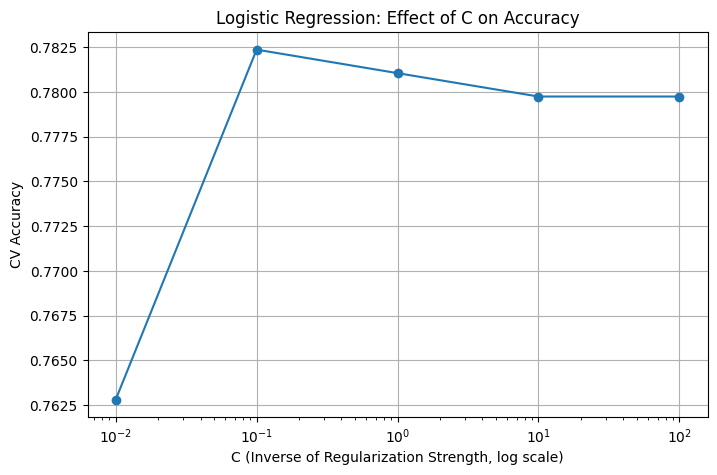

In [9]:
results_df = pd.DataFrame(grid_lr.cv_results_)

# Plot mean test score vs. C
plt.figure(figsize=(8, 5))
plt.plot(results_df['param_lr__C'].astype(float), results_df['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength, log scale)')
plt.ylabel('CV Accuracy')
plt.title('Logistic Regression: Effect of C on Accuracy')
plt.grid(True)
plt.show()

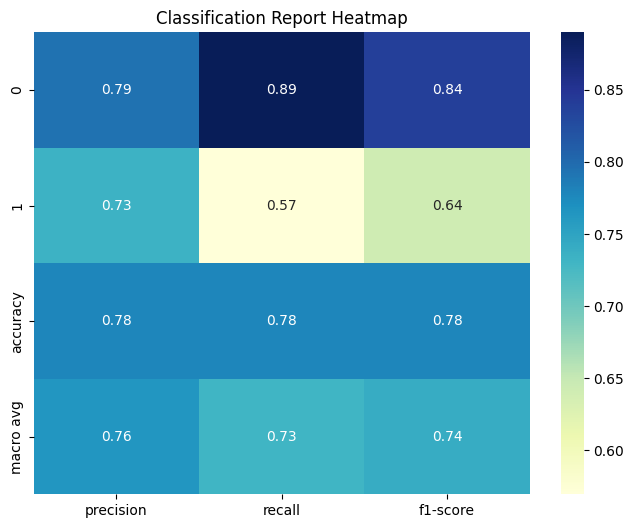

In [10]:
import seaborn as sns
from sklearn.metrics import classification_report

# Convert report to dict, then to DataFrame
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {
    'rfc__n_estimators': [50, 100, 200],
    'rfc__max_depth': [None, 5, 10],
    'rfc__min_samples_split': [2, 5]
}

pipeline_rf = Pipeline([
    ('std', StandardScaler()),       # Optional, doesn’t hurt
    ('rfc', RandomForestClassifier(random_state=42))
])

grid_rf = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_rf.fit(X, y)

print("🔍 Best RandomForest Params:", grid_rf.best_params_)
print(f"✅ Best RandomForest CV Accuracy: {grid_rf.best_score_:.4f}")

y_pred = grid_rf.predict(X)
print("\n random forest Classification Report:\n", classification_report(y, y_pred))

🔍 Best RandomForest Params: {'rfc__max_depth': 5, 'rfc__min_samples_split': 2, 'rfc__n_estimators': 200}
✅ Best RandomForest CV Accuracy: 0.7667

 random forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88       500
           1       0.83      0.66      0.73       267

    accuracy                           0.83       767
   macro avg       0.83      0.79      0.81       767
weighted avg       0.83      0.83      0.83       767



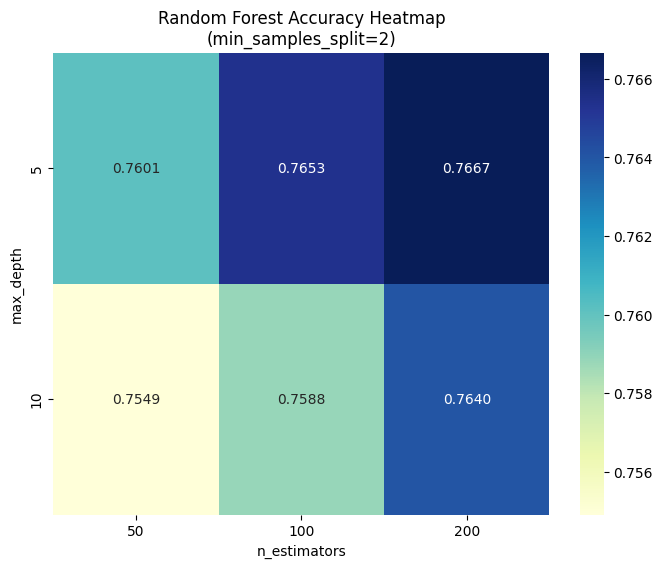

In [12]:
# Convert grid search results to DataFrame
results_df_rf = pd.DataFrame(grid_rf.cv_results_)

# Filter for a specific min_samples_split
subset = results_df_rf[results_df_rf['param_rfc__min_samples_split'] == 2]

# Pivot to prepare for heatmap
heatmap_data = subset.pivot_table(
    index='param_rfc__max_depth',
    columns='param_rfc__n_estimators',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap='YlGnBu')
plt.title("Random Forest Accuracy Heatmap\n(min_samples_split=2)")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()


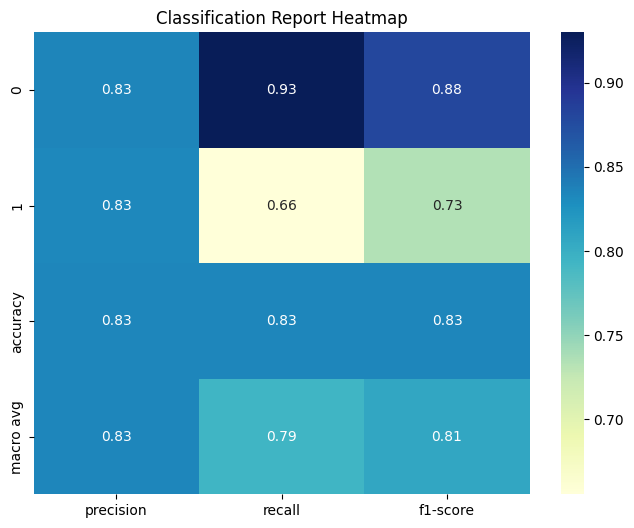

In [13]:
# Convert report to dict, then to DataFrame
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()

In [14]:
from sklearn.svm import SVC

pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC())
])

param_grid_svm = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(pipeline_svm, param_grid_svm, cv=cv, scoring='accuracy', n_jobs=-1)
grid_svm.fit(X, y)

print("🔍 SVM Best Params:", grid_svm.best_params_)
print(f"✅ SVM CV Accuracy: {grid_svm.best_score_:.4f}")

y_pred = grid_svm.predict(X)
print("\n SVM Classification Report:\n", classification_report(y, y_pred))

🔍 SVM Best Params: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
✅ SVM CV Accuracy: 0.7745

 SVM Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.84       500
           1       0.72      0.57      0.63       267

    accuracy                           0.77       767
   macro avg       0.76      0.72      0.73       767
weighted avg       0.77      0.77      0.77       767



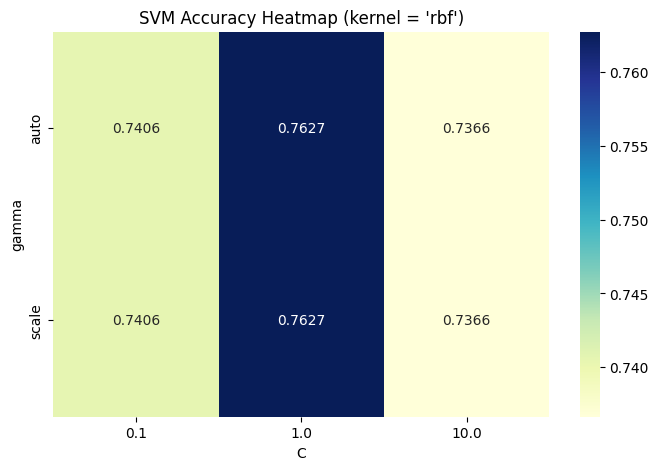

In [15]:
results_df_svm = pd.DataFrame(grid_svm.cv_results_)

# Filter only rbf kernel
rbf_df = results_df_svm[results_df_svm['param_svm__kernel'] == 'rbf']

# Pivot for heatmap (C vs gamma)
heatmap_rbf = rbf_df.pivot_table(
    index='param_svm__gamma',
    columns='param_svm__C',
    values='mean_test_score'
)

plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_rbf, annot=True, cmap='YlGnBu', fmt=".4f")
plt.title("SVM Accuracy Heatmap (kernel = 'rbf')")
plt.xlabel('C')
plt.ylabel('gamma')
plt.show()


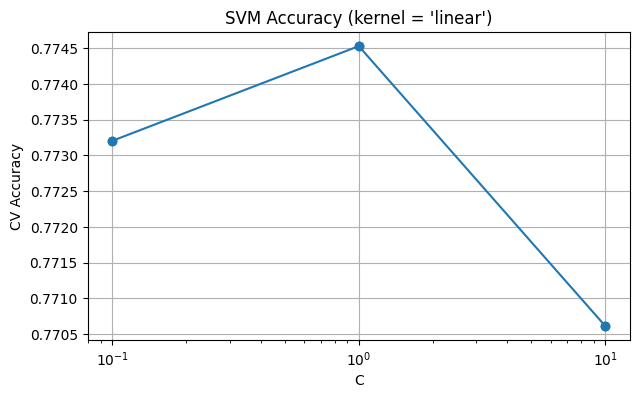

In [16]:
linear_df = results_df_svm[results_df_svm['param_svm__kernel'] == 'linear']

# Plot accuracy vs C for linear kernel
plt.figure(figsize=(7, 4))
plt.plot(linear_df['param_svm__C'].astype(float), linear_df['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('CV Accuracy')
plt.title("SVM Accuracy (kernel = 'linear')")
plt.grid(True)
plt.show()

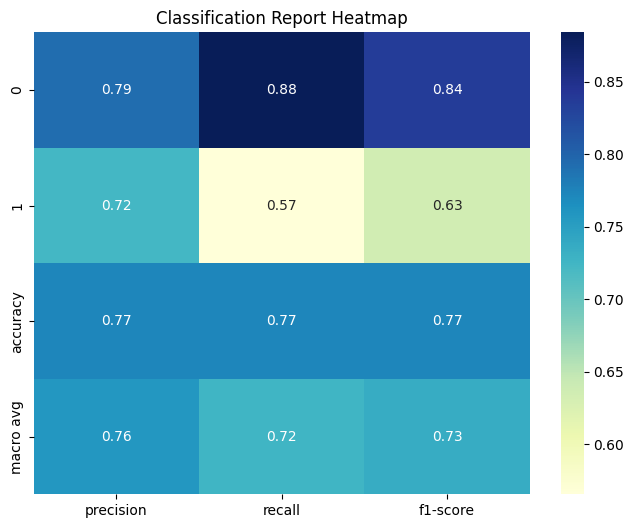

In [17]:
# Convert report to dict, then to DataFrame
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()

In [18]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(eval_metric='logloss', random_state=42)

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

grid_xgb = GridSearchCV(xgb_model, param_grid_xgb, cv=cv, scoring='accuracy', n_jobs=-1)
grid_xgb.fit(X, y)

print("🔍 XGBoost Best Params:", grid_xgb.best_params_)
print(f"✅ XGBoost CV Accuracy: {grid_xgb.best_score_:.4f}")

y_pred = grid_xgb.predict(X)
print("\n XGBoost Classification Report:\n", classification_report(y, y_pred))

🔍 XGBoost Best Params: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
✅ XGBoost CV Accuracy: 0.7627

 XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95       500
           1       0.94      0.86      0.90       267

    accuracy                           0.93       767
   macro avg       0.94      0.92      0.93       767
weighted avg       0.93      0.93      0.93       767



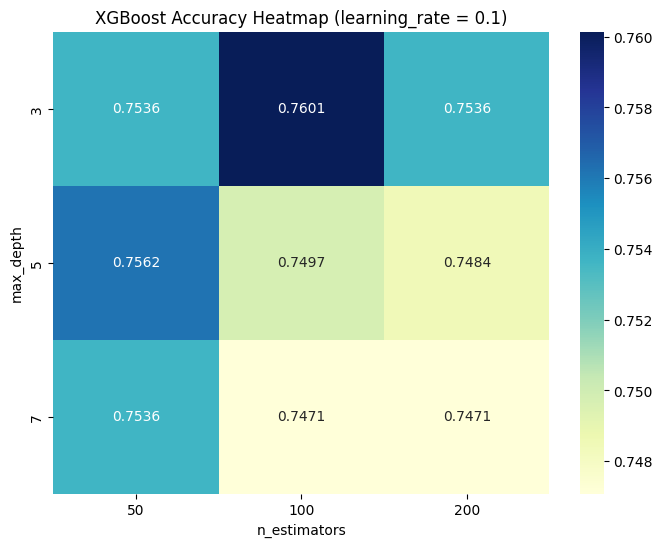

In [19]:
# Convert results to DataFrame
results_df_xgb = pd.DataFrame(grid_xgb.cv_results_)

# Filter for a specific learning_rate
subset = results_df_xgb[results_df_xgb['param_learning_rate'] == 0.1]

# Pivot for heatmap (max_depth vs n_estimators)
heatmap_data = subset.pivot_table(
    index='param_max_depth',
    columns='param_n_estimators',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap='YlGnBu')
plt.title("XGBoost Accuracy Heatmap (learning_rate = 0.1)")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

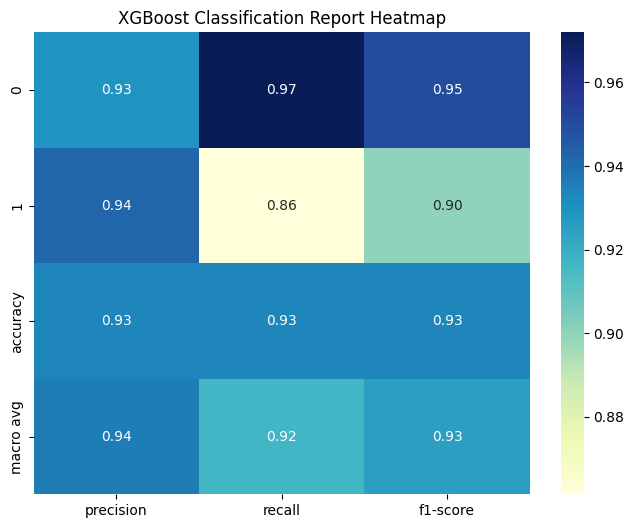

In [20]:
from sklearn.metrics import classification_report

report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("XGBoost Classification Report Heatmap")
plt.show()

In [21]:
from sklearn.naive_bayes import GaussianNB

grid_nb = GridSearchCV(GaussianNB(), {}, cv=cv, scoring='accuracy')
grid_nb.fit(X, y)

print("✅ NB Accuracy:", grid_nb.best_score_)

y_pred = grid_nb.predict(X)
print("\n NB Classification Report:\n", classification_report(y, y_pred))

✅ NB Accuracy: 0.7523809523809524

 NB Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.84      0.82       500
           1       0.68      0.61      0.64       267

    accuracy                           0.76       767
   macro avg       0.74      0.73      0.73       767
weighted avg       0.76      0.76      0.76       767



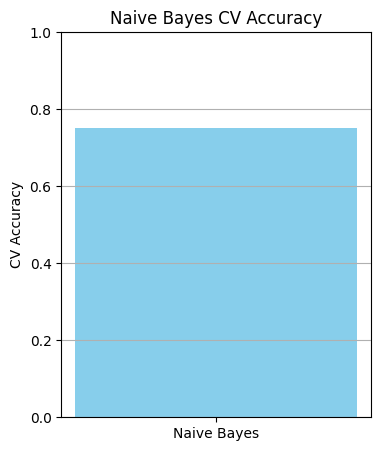

In [22]:
plt.figure(figsize=(4, 5))
plt.bar(['Naive Bayes'], [grid_nb.best_score_], color='skyblue')
plt.ylim(0, 1)
plt.ylabel('CV Accuracy')
plt.title('Naive Bayes CV Accuracy')
plt.grid(axis='y')
plt.show()

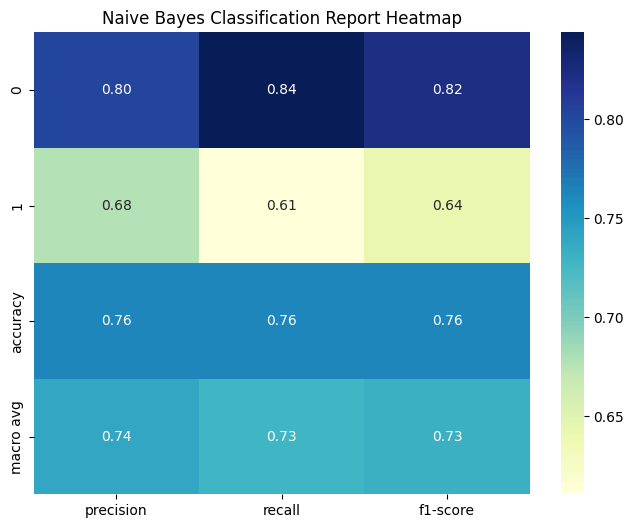

In [23]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Naive Bayes Classification Report Heatmap")
plt.show()

In [24]:
from sklearn.ensemble import AdaBoostClassifier

param_grid_ada = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.5, 1.0, 1.5]
}

grid_ada = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid_ada, cv=cv, scoring='accuracy')
grid_ada.fit(X, y)

print("🔍 AdaBoost Best Params:", grid_ada.best_params_)
print("✅ AdaBoost CV Accuracy:", grid_ada.best_score_)

y_pred = grid_ada.predict(X)
print("\n AdaBoost Classification Report:\n", classification_report(y, y_pred))

🔍 AdaBoost Best Params: {'learning_rate': 0.5, 'n_estimators': 100}
✅ AdaBoost CV Accuracy: 0.7705627705627706

 AdaBoost Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.75      0.58      0.66       267

    accuracy                           0.79       767
   macro avg       0.77      0.74      0.75       767
weighted avg       0.78      0.79      0.78       767



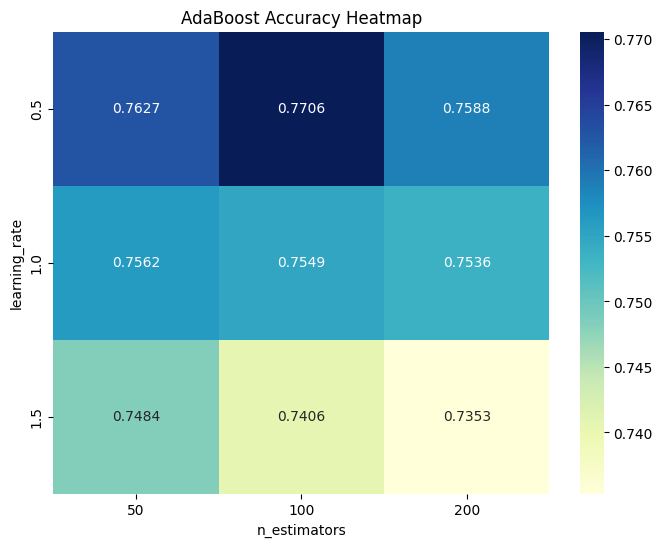

In [25]:
# Convert results to DataFrame
results_df_ada = pd.DataFrame(grid_ada.cv_results_)

# Pivot for heatmap
heatmap_data = results_df_ada.pivot_table(
    index='param_learning_rate',
    columns='param_n_estimators',
    values='mean_test_score'
)

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".4f")
plt.title("AdaBoost Accuracy Heatmap")
plt.xlabel("n_estimators")
plt.ylabel("learning_rate")
plt.show()

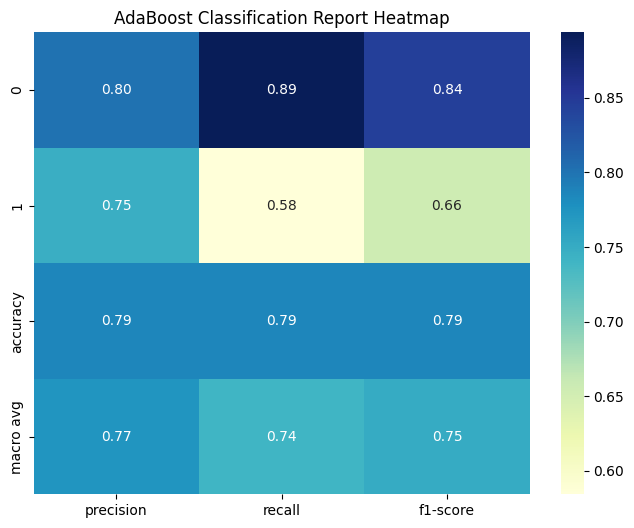

In [26]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("AdaBoost Classification Report Heatmap")
plt.show()

In [27]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=cv, scoring='accuracy')
grid_gb.fit(X, y)

print("🔍 Gradient Boosting Best Params:", grid_gb.best_params_)
print("✅ Gradient Boosting CV Accuracy:", grid_gb.best_score_)

y_pred = grid_gb.predict(X)
print("\n Gradient Boosting Classification Report:\n", classification_report(y, y_pred))

🔍 Gradient Boosting Best Params: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
✅ Gradient Boosting CV Accuracy: 0.760147695441813

 Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.95      0.86       500
           1       0.84      0.50      0.62       267

    accuracy                           0.79       767
   macro avg       0.81      0.72      0.74       767
weighted avg       0.80      0.79      0.78       767



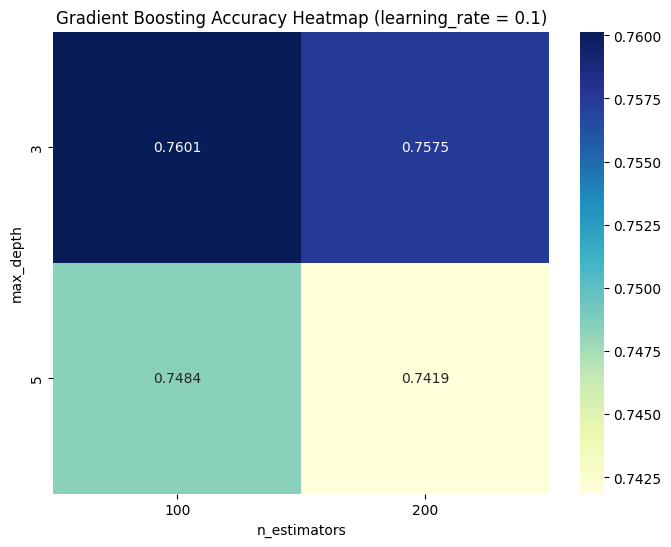

In [28]:
# Get grid search results as DataFrame
results_df_gb = pd.DataFrame(grid_gb.cv_results_)

# Filter for learning_rate = 0.1
subset = results_df_gb[results_df_gb['param_learning_rate'] == 0.1]

# Pivot for heatmap
heatmap_data = subset.pivot_table(
    index='param_max_depth',
    columns='param_n_estimators',
    values='mean_test_score'
)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".4f")
plt.title("Gradient Boosting Accuracy Heatmap (learning_rate = 0.1)")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

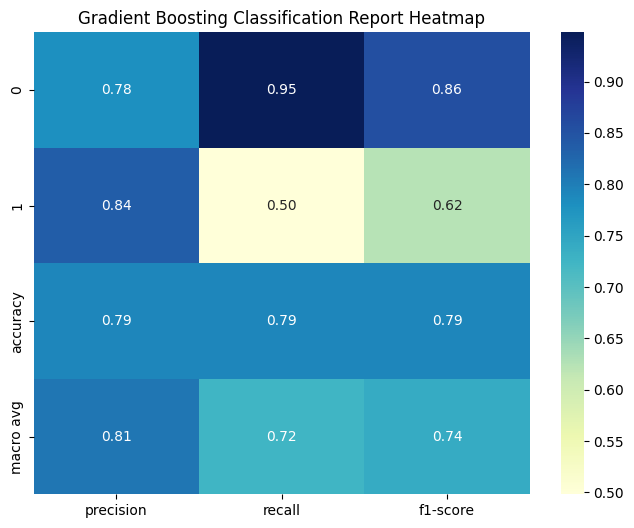

In [29]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Gradient Boosting Classification Report Heatmap")
plt.show()

In [30]:
from sklearn.neural_network import MLPClassifier

param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__learning_rate_init': [0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive']
}

pipeline_mlp = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(
        max_iter=2000,
        early_stopping=True,
        n_iter_no_change=10,
        random_state=42
    ))
])


grid_mlp = GridSearchCV(pipeline_mlp, param_grid_mlp, cv=5, scoring='accuracy')  # You can replace `cv` with your own cross-validation strategy
grid_mlp.fit(X, y)

print("🔍 MLP Best Params:", grid_mlp.best_params_)
print("✅ MLP CV Accuracy:", grid_mlp.best_score_)

y_pred = grid_mlp.predict(X)
print("\n MLP Classification Report:\n", classification_report(y, y_pred))

🔍 MLP Best Params: {'mlp__activation': 'tanh', 'mlp__hidden_layer_sizes': (50,), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': 0.01}
✅ MLP CV Accuracy: 0.7744418979713098

 MLP Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.86      0.83       500
           1       0.69      0.60      0.64       267

    accuracy                           0.77       767
   macro avg       0.75      0.73      0.74       767
weighted avg       0.76      0.77      0.76       767



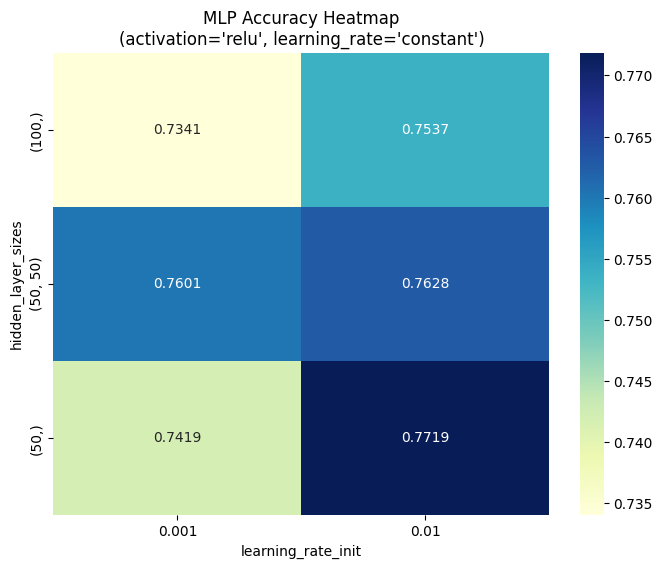

In [31]:
# Extract grid search results
results_df_mlp = pd.DataFrame(grid_mlp.cv_results_)

subset = results_df_mlp[
    (results_df_mlp['param_mlp__activation'] == 'relu') &
    (results_df_mlp['param_mlp__learning_rate'] == 'constant')
].copy()

subset['param_mlp__hidden_layer_sizes'] = subset['param_mlp__hidden_layer_sizes'].astype(str)

# Pivot table for heatmap
heatmap_data = subset.pivot_table(
    index='param_mlp__hidden_layer_sizes',
    columns='param_mlp__learning_rate_init',
    values='mean_test_score'
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap='YlGnBu')
plt.title("MLP Accuracy Heatmap\n(activation='relu', learning_rate='constant')")
plt.xlabel("learning_rate_init")
plt.ylabel("hidden_layer_sizes")
plt.show()


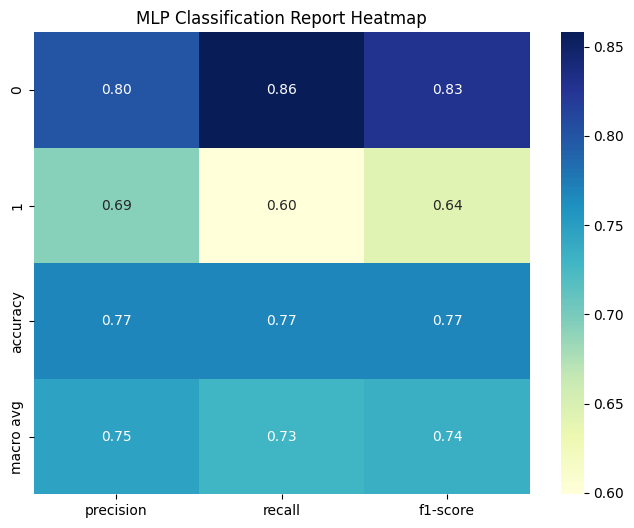

In [32]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("MLP Classification Report Heatmap")
plt.show()

In [33]:
from lightgbm import LGBMClassifier

param_grid_lgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, -1],  # -1 means no limit
    'min_data_in_leaf': [1, 5, 10]
}

# Setup GridSearchCV
grid_lgb = GridSearchCV(
    estimator=LGBMClassifier(random_state=42),
    param_grid=param_grid_lgb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

# Fit model
grid_lgb.fit(X, y)

# Print results without emojis to avoid matplotlib font warnings
print("\n🔍 LightGBM Best Params:", grid_lgb.best_params_)
print("✅ LightGBM CV Accuracy:", grid_lgb.best_score_)

# Predict on the training data
y_pred = grid_lgb.predict(X)

# Classification report
print("\n📄 LightGBM Classification Report:\n", classification_report(y, y_pred))

[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Info] Number of positive: 267, number of negative: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000136 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 764
[LightGBM] [Info] Number of data points in the train set: 767, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348110 -> initscore=-0.627359
[LightGBM] [Info] Start training from score -0.627359

🔍 LightGBM Best Params: {'learning_rate': 0.01, 'max_depth': -1, 'min_data_in_leaf': 1, 'n_estimators': 100}
✅ LightGBM CV Accuracy: 0.7731516849163909
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1



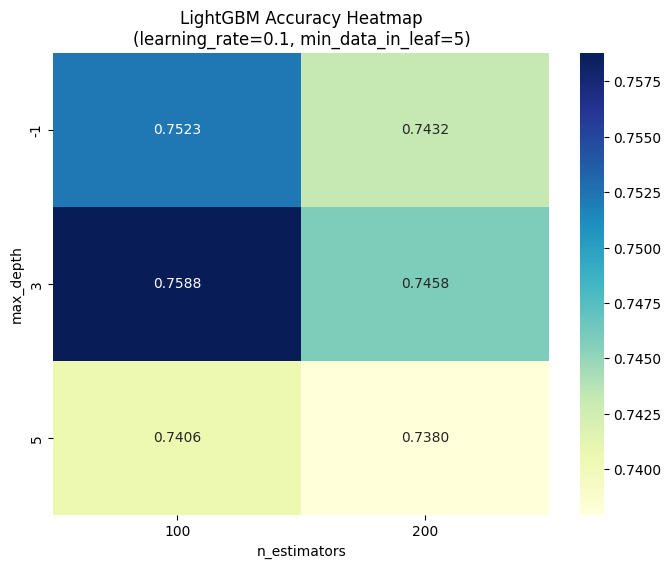

In [34]:
# Convert to DataFrame
results_df_lgb = pd.DataFrame(grid_lgb.cv_results_)

# Make an explicit copy to avoid chained assignment and dtype issues
subset = results_df_lgb[
    (results_df_lgb['param_learning_rate'] == 0.1) &
    (results_df_lgb['param_min_data_in_leaf'] == 5)
].copy()

# Convert 'param_max_depth' to string in the copied DataFrame
subset['param_max_depth'] = subset['param_max_depth'].astype(str)

# Pivot for heatmap
heatmap_data = subset.pivot_table(
    index='param_max_depth',
    columns='param_n_estimators',
    values='mean_test_score'
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".4f")
plt.title("LightGBM Accuracy Heatmap\n(learning_rate=0.1, min_data_in_leaf=5)")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

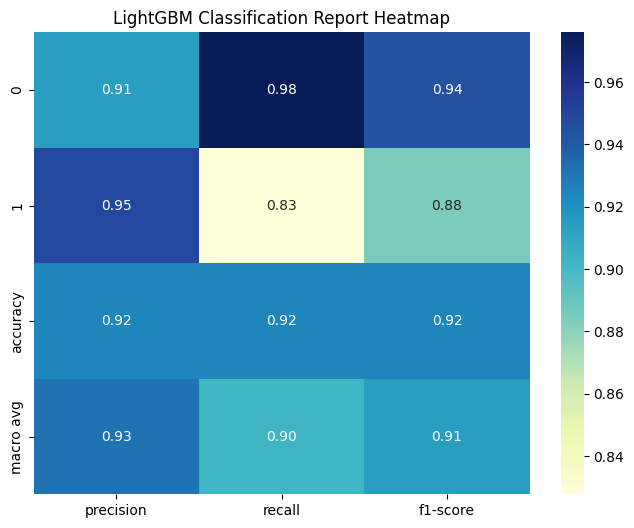

In [35]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("LightGBM Classification Report Heatmap")
plt.show()

In [36]:
from catboost import CatBoostClassifier

param_grid_cat = {
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'iterations': [100, 200]
}

grid_cat = GridSearchCV(
    CatBoostClassifier(verbose=0, random_state=42),
    param_grid_cat,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_cat.fit(X, y)
print("\n🔍 CatBoost Best Params:", grid_cat.best_params_)
print("✅ CatBoost CV Accuracy:", grid_cat.best_score_)

y_pred = grid_cat.predict(X)
print("\n📄 CatBoost Classification Report:\n", classification_report(y, y_pred))


🔍 CatBoost Best Params: {'depth': 6, 'iterations': 200, 'learning_rate': 0.01}
✅ CatBoost CV Accuracy: 0.7705797470503353

📄 CatBoost Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88       500
           1       0.82      0.65      0.73       267

    accuracy                           0.83       767
   macro avg       0.83      0.79      0.80       767
weighted avg       0.83      0.83      0.82       767



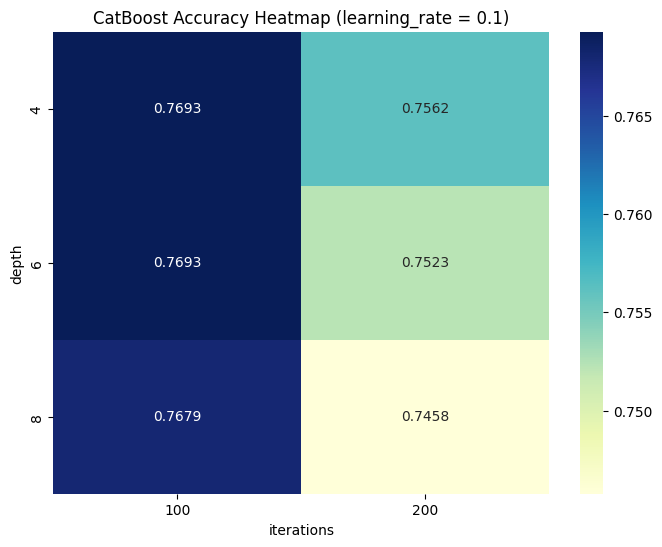

In [37]:
# Convert to DataFrame
results_df_cat = pd.DataFrame(grid_cat.cv_results_)

# Filter for learning_rate = 0.1
subset = results_df_cat[results_df_cat['param_learning_rate'] == 0.1]

# Pivot table: rows = depth, columns = iterations
heatmap_data = subset.pivot_table(
    index='param_depth',
    columns='param_iterations',
    values='mean_test_score'
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".4f", cmap='YlGnBu')
plt.title("CatBoost Accuracy Heatmap (learning_rate = 0.1)")
plt.xlabel("iterations")
plt.ylabel("depth")
plt.show()


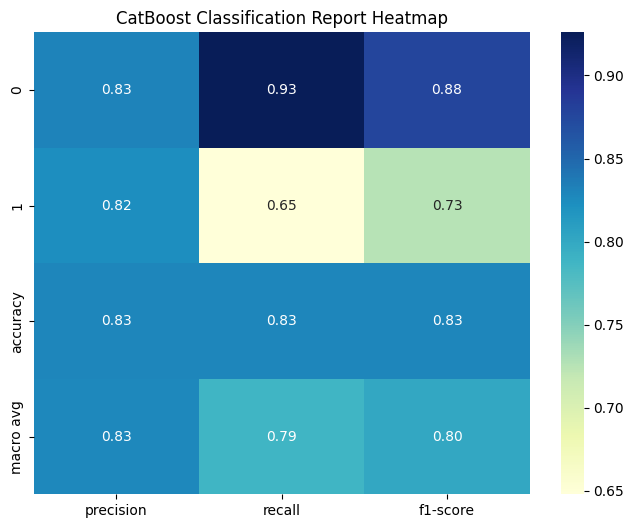

In [38]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("CatBoost Classification Report Heatmap")
plt.show()

In [39]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {
    'knn__n_neighbors': range(1, 21)
}

pipeline_knn = Pipeline([
    ('std', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

grid_knn = GridSearchCV(
    estimator=pipeline_knn,
    param_grid=param_grid_knn,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_knn.fit(X, y)

print("🔍 Best KNN Params:", grid_knn.best_params_)
print(f"✅ Best KNN CV Accuracy: {grid_knn.best_score_:.4f}")

y_pred = grid_knn.predict(X)
print("\n📄 KNN Classification Report:\n", classification_report(y, y_pred))

🔍 Best KNN Params: {'knn__n_neighbors': 19}
✅ Best KNN CV Accuracy: 0.7562

📄 KNN Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84       500
           1       0.73      0.55      0.63       267

    accuracy                           0.77       767
   macro avg       0.76      0.72      0.73       767
weighted avg       0.77      0.77      0.76       767



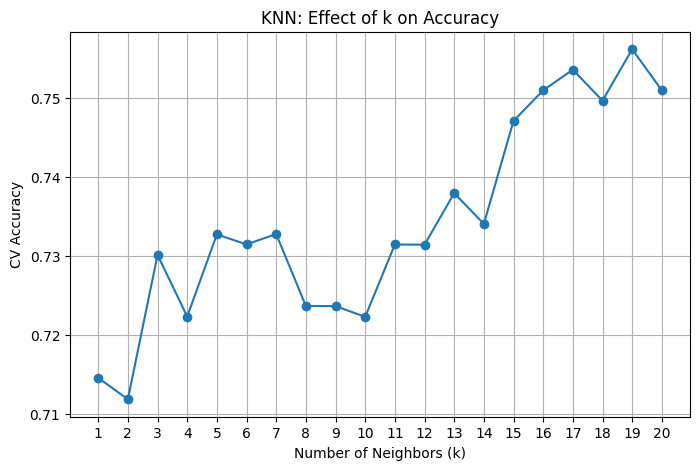

In [40]:
# Extract grid search results
results_df_knn = pd.DataFrame(grid_knn.cv_results_)

# Plot accuracy vs n_neighbors
plt.figure(figsize=(8, 5))
plt.plot(results_df_knn['param_knn__n_neighbors'], results_df_knn['mean_test_score'], marker='o')
plt.xticks(range(1, 21))
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('CV Accuracy')
plt.title('KNN: Effect of k on Accuracy')
plt.grid(True)
plt.show()

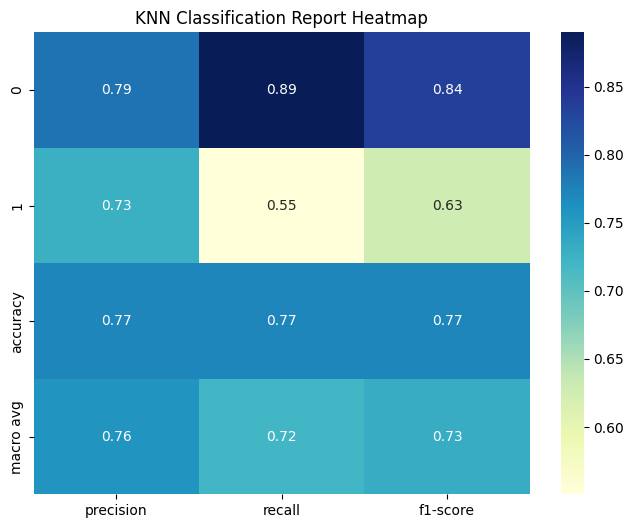

In [41]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("KNN Classification Report Heatmap")
plt.show()

In [42]:
from sklearn.tree import DecisionTreeClassifier
param_grid_dt = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)

grid_dt.fit(X, y)

print("🌳 Decision Tree Best Params:", grid_dt.best_params_)
print(f"✅ Decision Tree CV Accuracy: {grid_dt.best_score_:.4f}")

y_pred = grid_dt.predict(X)
print("\n📄 Decision Tree Classification Report:\n", classification_report(y, y_pred))

🌳 Decision Tree Best Params: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}
✅ Decision Tree CV Accuracy: 0.7562

📄 Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83       500
           1       0.69      0.63      0.66       267

    accuracy                           0.77       767
   macro avg       0.75      0.74      0.74       767
weighted avg       0.77      0.77      0.77       767



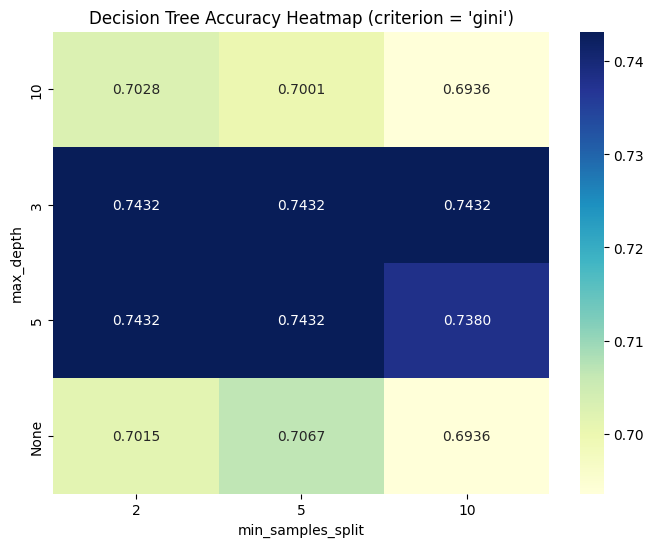

In [43]:
# Convert grid search results to DataFrame
results_df_dt = pd.DataFrame(grid_dt.cv_results_)

# Filter for a specific criterion and make a copy to avoid warnings
subset = results_df_dt[results_df_dt['param_criterion'] == 'gini'].copy()

# Convert max_depth to string to include None in heatmap labels
subset['param_max_depth'] = subset['param_max_depth'].astype(str)

# Pivot table: max_depth vs min_samples_split
heatmap_data = subset.pivot_table(
    index='param_max_depth',
    columns='param_min_samples_split',
    values='mean_test_score'
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".4f")
plt.title("Decision Tree Accuracy Heatmap (criterion = 'gini')")
plt.xlabel("min_samples_split")
plt.ylabel("max_depth")
plt.show()

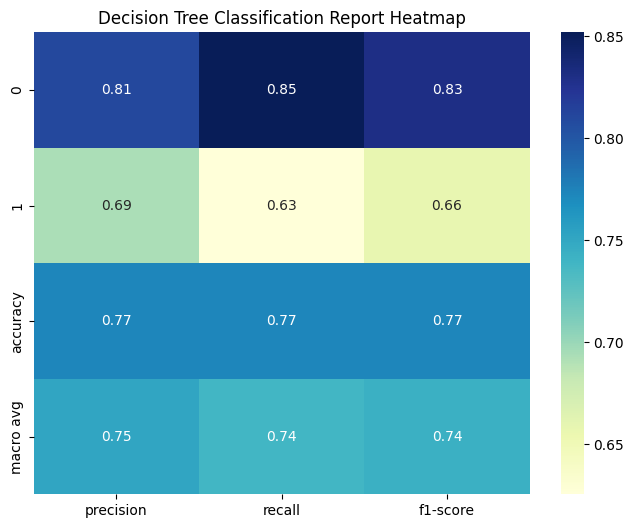

In [44]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Decision Tree Classification Report Heatmap")
plt.show()

In [45]:
from sklearn.linear_model import RidgeClassifier

grid_ridge = GridSearchCV(RidgeClassifier(), {'alpha': [0.1, 1.0, 10.0]}, cv=cv, scoring='accuracy')
grid_ridge.fit(X, y)
print("🔍 RidgeClassifier Params:", grid_ridge.best_params_)
print("✅ RidgeClassifier CV Accuracy:", grid_ridge.best_score_)

y_pred = grid_ridge.predict(X)
print("\n📄 RidgeClassifier Classification Report:\n", classification_report(y, y_pred))

🔍 RidgeClassifier Params: {'alpha': 0.1}
✅ RidgeClassifier CV Accuracy: 0.7784483490365843

📄 RidgeClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.89      0.84       500
           1       0.74      0.57      0.65       267

    accuracy                           0.78       767
   macro avg       0.77      0.73      0.74       767
weighted avg       0.78      0.78      0.77       767



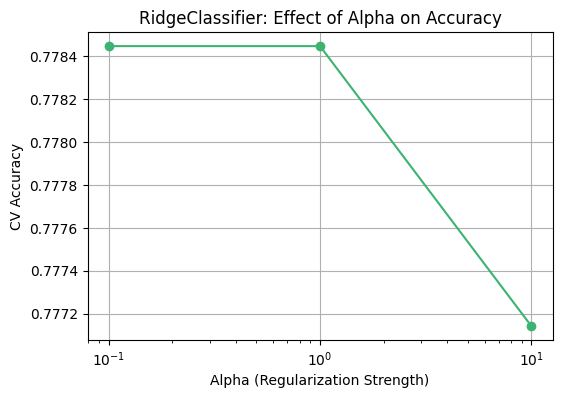

In [46]:
# Convert grid results to DataFrame
results_df_ridge = pd.DataFrame(grid_ridge.cv_results_)

# Plot mean test score vs. alpha
plt.figure(figsize=(6, 4))
plt.plot(results_df_ridge['param_alpha'], results_df_ridge['mean_test_score'], marker='o', color='mediumseagreen')
plt.xscale('log')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('CV Accuracy')
plt.title('RidgeClassifier: Effect of Alpha on Accuracy')
plt.grid(True)
plt.show()

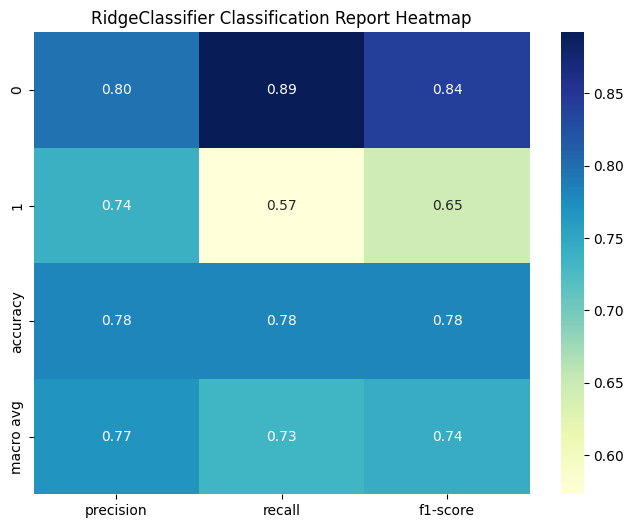

In [47]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("RidgeClassifier Classification Report Heatmap")
plt.show()

In [48]:
from sklearn.linear_model import SGDClassifier

param_grid_sgd = {
    'loss': ['hinge', 'log_loss'],
    'alpha': [0.0001, 0.001, 0.01]
}

grid_sgd = GridSearchCV(SGDClassifier(max_iter=1000, random_state=42), param_grid_sgd, cv=cv, scoring='accuracy')
grid_sgd.fit(X, y)
print("🔍 SGDClassifier Params:", grid_sgd.best_params_)
print("✅ SGDClassifier CV Accuracy:", grid_sgd.best_score_)

y_pred = grid_sgd.predict(X)
print("\n📄 SGDClassifier Classification Report:\n", classification_report(y, y_pred))

🔍 SGDClassifier Params: {'alpha': 0.01, 'loss': 'log_loss'}
✅ SGDClassifier CV Accuracy: 0.653195823784059

📄 SGDClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.84      0.77       500
           1       0.56      0.38      0.45       267

    accuracy                           0.68       767
   macro avg       0.64      0.61      0.61       767
weighted avg       0.66      0.68      0.66       767



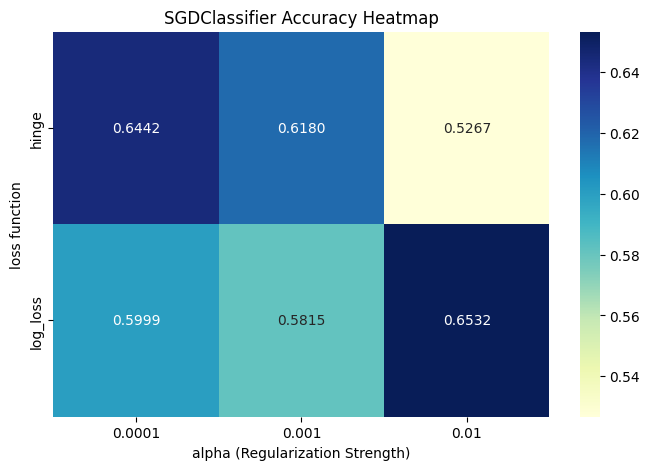

In [49]:
# Convert grid search results to DataFrame
results_df_sgd = pd.DataFrame(grid_sgd.cv_results_)

# Pivot table: loss vs alpha
heatmap_data = results_df_sgd.pivot_table(
    index='param_loss',
    columns='param_alpha',
    values='mean_test_score'
)

# Plot heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".4f")
plt.title("SGDClassifier Accuracy Heatmap")
plt.xlabel("alpha (Regularization Strength)")
plt.ylabel("loss function")
plt.show()

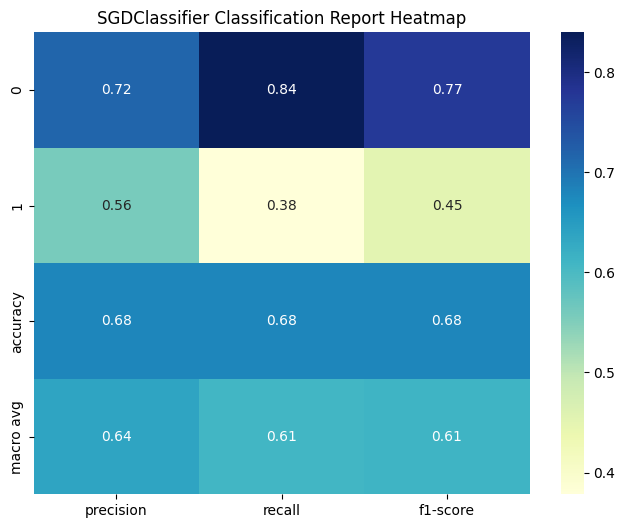

In [50]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("SGDClassifier Classification Report Heatmap")
plt.show()

In [51]:
from sklearn.ensemble import ExtraTreesClassifier

param_grid_etc = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10]
}

grid_etc = GridSearchCV(ExtraTreesClassifier(random_state=42), param_grid_etc, cv=cv, scoring='accuracy')
grid_etc.fit(X, y)
print("🔍 ExtraTrees Params:", grid_etc.best_params_)
print("✅ ExtraTrees CV Accuracy:", grid_etc.best_score_)

y_pred = grid_etc.predict(X)
print("\n📄 ExtraTrees Classification Report:\n", classification_report(y, y_pred))

🔍 ExtraTrees Params: {'max_depth': 10, 'n_estimators': 200}
✅ ExtraTrees CV Accuracy: 0.7692810457516339

📄 ExtraTrees Classification Report:
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       500
           1       1.00      0.76      0.86       267

    accuracy                           0.92       767
   macro avg       0.94      0.88      0.90       767
weighted avg       0.92      0.92      0.91       767



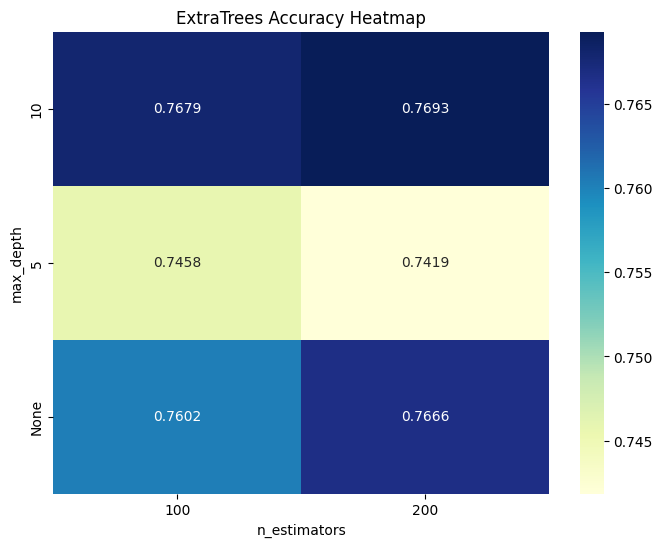

In [52]:
# Extract results
results_df_etc = pd.DataFrame(grid_etc.cv_results_)

# Convert `None` to string for heatmap labeling
results_df_etc['param_max_depth'] = results_df_etc['param_max_depth'].astype(str)

# Pivot table
heatmap_data = results_df_etc.pivot_table(
    index='param_max_depth',
    columns='param_n_estimators',
    values='mean_test_score'
)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt=".4f")
plt.title("ExtraTrees Accuracy Heatmap")
plt.xlabel("n_estimators")
plt.ylabel("max_depth")
plt.show()

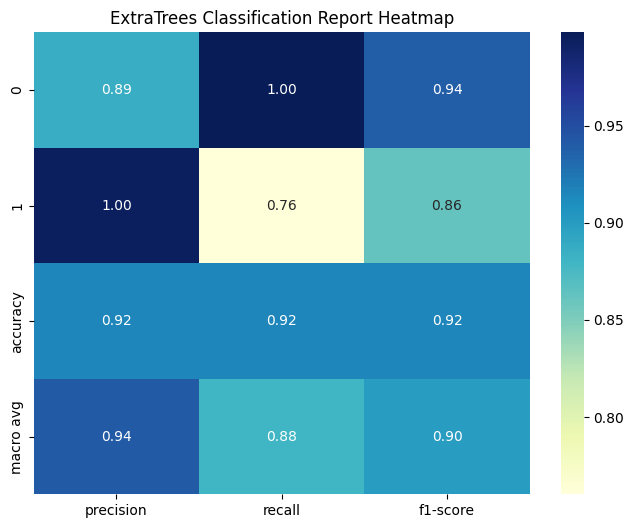

In [53]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("ExtraTrees Classification Report Heatmap")
plt.show()

In [54]:
from sklearn.ensemble import StackingClassifier

# Define stacking model
stacking_model = StackingClassifier(
    estimators=[
        ('rf', grid_rf.best_estimator_),
        ('knn', grid_knn.best_estimator_),
        ('svm', grid_svm.best_estimator_)
    ],
    final_estimator=LogisticRegression(max_iter=1000)
)

# Define parameter grid for LogisticRegression's C
param_grid = {
    'final_estimator__C': [0.01, 0.1, 1, 10, 100]
}

# Perform grid search
grid_stack = GridSearchCV(stacking_model, param_grid, cv=cv, scoring='accuracy')
grid_stack.fit(X, y)

# Print results
print("✅ StackingClassifier CV Accuracy:", grid_stack.best_score_)

y_pred = grid_stack.predict(X)
print("\n📄 StackingClassifier Classification Report:\n", classification_report(y, y_pred))

✅ StackingClassifier CV Accuracy: 0.7758254817078346

📄 StackingClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.90      0.84       500
           1       0.75      0.58      0.65       267

    accuracy                           0.78       767
   macro avg       0.77      0.74      0.75       767
weighted avg       0.78      0.78      0.78       767



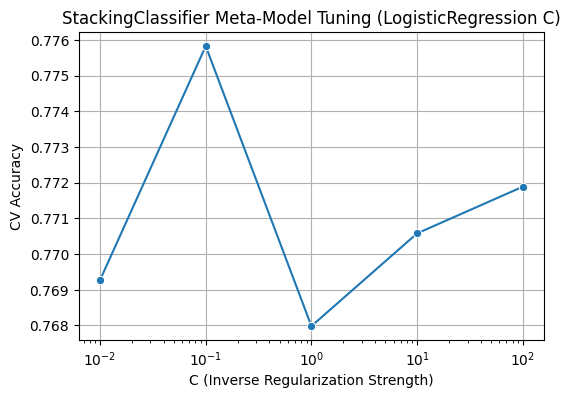

In [55]:
results_df_stack = pd.DataFrame(grid_stack.cv_results_)

plt.figure(figsize=(6, 4))
sns.lineplot(x='param_final_estimator__C', y='mean_test_score', marker='o', data=results_df_stack)
plt.xscale('log')
plt.xlabel("C (Inverse Regularization Strength)")
plt.ylabel("CV Accuracy")
plt.title("StackingClassifier Meta-Model Tuning (LogisticRegression C)")
plt.grid(True)
plt.show()


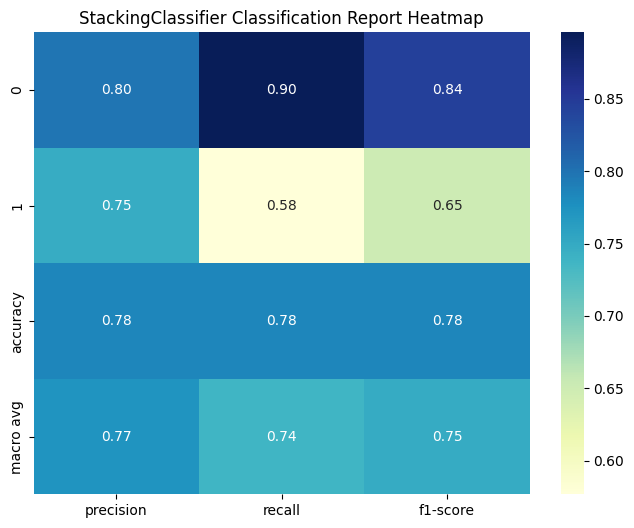

In [56]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("StackingClassifier Classification Report Heatmap")
plt.show()

In [57]:
from sklearn.ensemble import VotingClassifier

# VotingClassifier with weights (to be tuned)
voting_model = VotingClassifier(
    estimators=[
        ('lr', grid_lr.best_estimator_),
        ('rf', grid_rf.best_estimator_),
        ('xgb', grid_xgb.best_estimator_)
    ],
    voting='soft'
)

# Grid of weights
param_grid = {
    'weights': [
        [1, 1, 1],
        [2, 1, 1],
        [1, 2, 1],
        [1, 1, 2],
        [2, 2, 1],
        [1, 2, 2],
        [2, 1, 2],
        [3, 1, 1],
        [1, 3, 1],
        [1, 1, 3]
    ]
}

grid_voting_weighted = GridSearchCV(voting_model, param_grid, cv=cv, scoring='accuracy')
grid_voting_weighted.fit(X, y)

print("✅ VotingClassifier CV Accuracy:", grid_voting_weighted.best_score_)

y_pred = grid_voting_weighted.predict(X)
print("\n📄 VotingClassifier Classification Report:\n", classification_report(y, y_pred))

✅ VotingClassifier CV Accuracy: 0.7718869365928189

📄 VotingClassifier Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.94      0.90       500
           1       0.86      0.71      0.78       267

    accuracy                           0.86       767
   macro avg       0.86      0.83      0.84       767
weighted avg       0.86      0.86      0.86       767



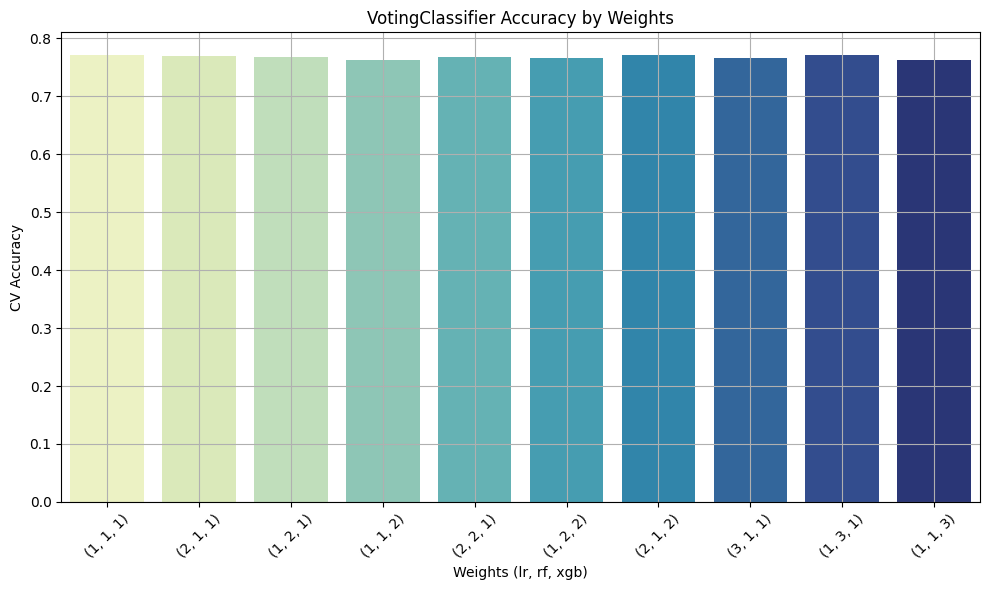

In [58]:
# Extract results
results_df_vote = pd.DataFrame(grid_voting_weighted.cv_results_)
results_df_vote['weights_str'] = results_df_vote['param_weights'].apply(lambda x: str(tuple(x)))

# Plot heatmap-like bar chart
plt.figure(figsize=(10, 6))
sns.barplot(
    x='weights_str',
    y='mean_test_score',
    hue='weights_str',  # <- assign x to hue
    data=results_df_vote,
    palette='YlGnBu',
    dodge=False,         # <- avoid bar separation due to hue
    legend=False         # <- hide redundant legend
)
plt.xticks(rotation=45)
plt.ylabel("CV Accuracy")
plt.xlabel("Weights (lr, rf, xgb)")
plt.title("VotingClassifier Accuracy by Weights")
plt.grid(True)
plt.tight_layout()
plt.show()

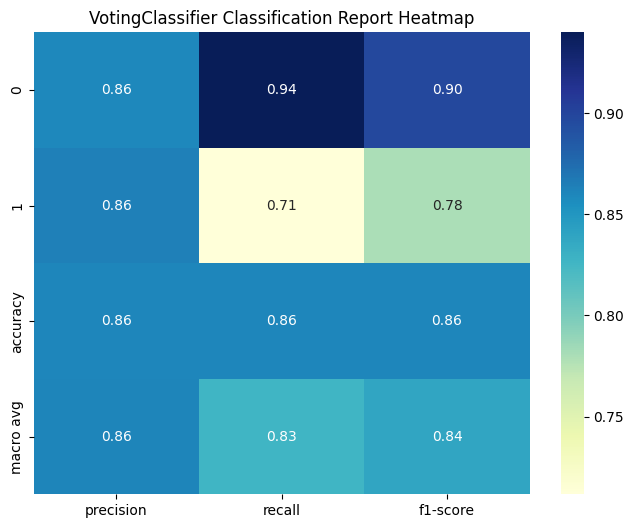

In [59]:
report = classification_report(y, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("VotingClassifier Classification Report Heatmap")
plt.show()

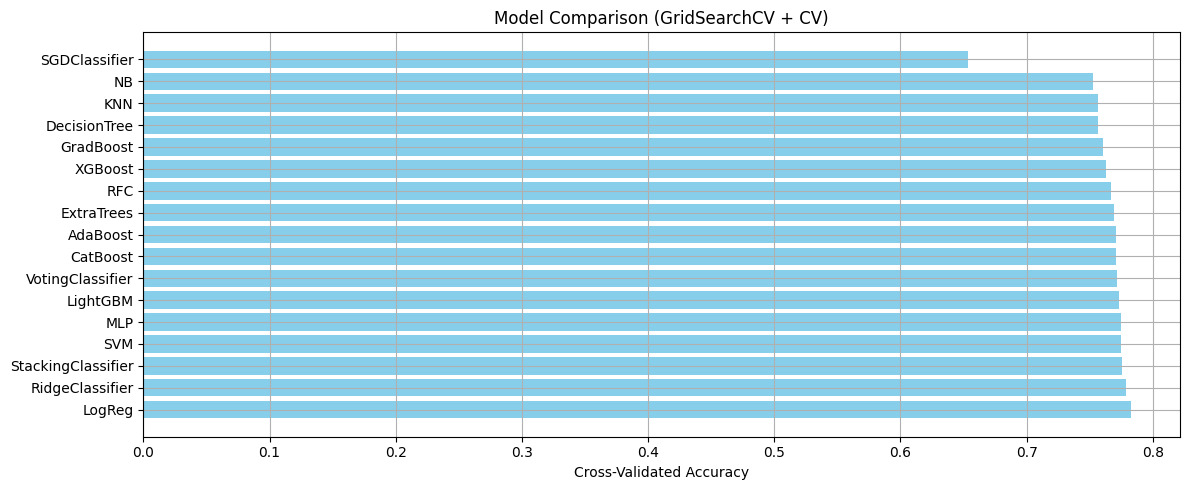

In [60]:
models = {
    "LogReg": grid_lr.best_score_,
    "KNN": grid_knn.best_score_,
    "SVM": grid_svm.best_score_,
    "RFC": grid_rf.best_score_,
    "XGBoost": grid_xgb.best_score_,
    "AdaBoost": grid_ada.best_score_,
    "GradBoost": grid_gb.best_score_,
    "MLP": grid_mlp.best_score_,
    "NB": grid_nb.best_score_,
    "LightGBM": grid_lgb.best_score_,
    "CatBoost": grid_cat.best_score_,
    "DecisionTree": grid_dt.best_score_,
    "RidgeClassifier": grid_ridge.best_score_,
    "SGDClassifier": grid_sgd.best_score_,
    "ExtraTrees": grid_etc.best_score_,
    "StackingClassifier": grid_stack.best_score_,
    "VotingClassifier": grid_voting_weighted.best_score_
}

# Sort updated models
sorted_models = dict(sorted(models.items(), key=lambda item: item[1], reverse=True))

# Plot
plt.figure(figsize=(12, 5))
plt.barh(list(sorted_models.keys()), list(sorted_models.values()), color='skyblue')
plt.xlabel("Cross-Validated Accuracy")
plt.title("Model Comparison (GridSearchCV + CV)")
plt.grid(True)
plt.tight_layout()
plt.show()
